<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model_D4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# PRUEBAS CON MODELO D4

8 características: mediana, desv.típica, max, min, desv.típica 1ªdif, mediana 1ªdif, AuC, potencia

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from math import ceil

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [39]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_D4.csv'
column_names = ['Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff',
                'Total Area', 'Power', 'State']

raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

class_counts = raw_dataset['State'].value_counts()
print("Recuento de instancias por clase:")
print(class_counts)

Formato del dataset: (4471, 9)
Recuento de instancias por clase:
State
1    2739
0    1732
Name: count, dtype: int64


In [24]:
raw_dataset.head()  # muestra las primeras 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Standard Dev 1st diff,Median 1st diff,Total Area,Power,State
0,0.394602,0.008719,0.404852,0.338231,0.004694,0.0,46.926934,18.642839,0
1,0.370260,0.004848,0.381791,0.358729,0.000870,0.0,44.262093,16.605095,0
2,0.353605,0.004257,0.366417,0.347199,0.001046,0.0,42.005295,14.958530,0
3,0.354886,0.003209,0.363854,0.351042,0.000773,0.0,42.353775,15.200105,0
4,0.366417,0.008975,0.377947,0.351042,0.001392,0.0,43.537582,16.071188,0


In [42]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

,Median,Standard Dev,Max Value,Min Value,Standard Dev 1st diff,Median 1st diff,Total Area,Power,State
4466,1.945523,1.216579,2.939124,0.003442,0.153839,0.002383,179.209253,447.869535,1
4467,0.054666,0.880522,2.840681,0.008959,0.144910,-0.001741,59.182331,122.629478,1
4468,2.975998,0.982996,3.025988,0.056952,0.089213,0.001360,298.406455,864.623898,1
4469,2.945381,0.028301,2.984894,2.740868,0.024742,-0.000431,350.219999,1039.485025,1
4470,2.864765,0.263631,2.905832,0.000000,0.257441,-0.000474,339.177011,975.176900,1


## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [40]:
# Extracción de subconjuntos: bloque de código para mantener la proporción de clases
from sklearn.model_selection import train_test_split

features = raw_dataset.drop('State', axis=1)
labels = raw_dataset['State']
train_dataset, test_dataset, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, stratify=labels, random_state=0)

In [41]:
train_size = train_dataset.shape
test_size = test_dataset.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

Formato del dataset de training: (3576, 8)
Formato del dataset de test: (895, 8)


,count,mean,std,min,25%,50%,75%,max
Median,3576.0,1.346710,2.501420,1.420146e-26,0.234650,0.421630,1.008745,17.071788
Standard Dev,3576.0,0.137108,0.355548,4.853805e-04,0.005697,0.026674,0.105472,6.510492
Max Value,3576.0,1.615578,2.779556,4.779257e-03,0.285077,0.481583,1.386700,17.572711
Min Value,3576.0,1.104165,2.289607,0.000000e+00,0.121742,0.299272,0.689327,16.098618
Standard Dev 1st diff,3576.0,0.022908,0.043060,3.494808e-04,0.001294,0.005874,0.023028,0.342919
Median 1st diff,3576.0,-0.000297,0.003752,-1.093078e-01,-0.000342,-0.000015,0.000182,0.048991
Total Area,3576.0,160.119634,296.017410,3.457700e-02,28.104771,50.126552,121.227622,2029.800593
Power,3576.0,976.831817,3409.711622,1.060477e-04,7.180186,22.086482,143.468519,34873.191308


### 3.2. Normalización y estandarización de todos los datos

In [43]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

Formato del dataset de training: (3576, 8)
Formato del dataset de test: (895, 8)


,count,mean,std,min,25%,50%,75%,max
Median,3576.0,8.643347e-17,1.0,-0.538378,-0.444571,-0.369822,-0.135109,6.286461
Standard Dev,3576.0,-1.639255e-17,1.0,-0.384258,-0.369600,-0.310600,-0.088976,17.925512
Max Value,3576.0,-4.967441e-18,1.0,-0.579517,-0.478674,-0.407977,-0.082344,5.740893
Min Value,3576.0,-8.941393e-17,1.0,-0.482251,-0.429079,-0.351542,-0.181183,6.548921
Standard Dev 1st diff,3576.0,-1.986976e-17,1.0,-0.523894,-0.501950,-0.395591,0.002770,7.431729
Median 1st diff,3576.0,-1.192186e-17,1.0,-29.057316,-0.011993,0.075149,0.127531,13.137913
Total Area,3576.0,3.278511e-17,1.0,-0.540796,-0.445970,-0.371576,-0.131384,6.316118
Power,3576.0,3.377860e-17,1.0,-0.286485,-0.284379,-0.280008,-0.244409,9.941122


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [44]:
from keras import Sequential, layers, activations

In [ ]:
def build_model_A(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_A(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_45 (Conv1D)              │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 216)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 22)             │         4,774 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,878 (19.05 KB)

 Trainable params: 4,878 (19.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_model_B(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_B(train_size)
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)              │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (None, 8, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 22)             │         3,894 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,802 (22.66 KB)

 Trainable params: 5,802 (22.66 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_model_C1(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C1(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)              │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 8, 27)          │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_47 (Conv1D)              │ (None, 8, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 8, 22)          │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_48 (Conv1D)              │ (None, 8, 18)          │         1,206 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 8, 18)          │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 22)             │         3,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,572 (25.67 KB)

 Trainable params: 6,438 (25.15 KB)

 Non-trainable params: 134 (536.00 B)

In [ ]:
def build_model_C2(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Conv1D(18, 3, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C2(train_size)
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_35 (Conv1D)              │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_36 (Conv1D)              │ (None, 8, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_37 (Conv1D)              │ (None, 8, 18)          │         1,206 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 22)             │         3,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,304 (24.62 KB)

 Trainable params: 6,304 (24.62 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
def build_model_C3(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C3(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 27)          │           108 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 8, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 22)          │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 18)          │         1,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 18)          │            72 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 22)             │         3,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,968 (27.22 KB)

 Trainable params: 6,834 (26.70 KB)

 Non-trainable params: 134 (536.00 B)

In [ ]:
def build_model_C4(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.Conv1D(22, 3, padding='same', activation='relu'))
  model.add(layers.Conv1D(18, 4, padding='same', activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modelo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_C4(train_size)
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_41 (Conv1D)              │ (None, 8, 27)          │            81 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 8, 22)          │         1,804 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_43 (Conv1D)              │ (None, 8, 18)          │         1,602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 144)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 22)             │         3,190 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            23 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,700 (26.17 KB)

 Trainable params: 6,700 (26.17 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [ ]:
from keras import callbacks
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',       # o 'val_accuracy'
    patience=100,              # número de épocas que espera sin mejora
    restore_best_weights=True  # para recuperar los mejores pesos
)

In [50]:
EPOCHS = 1000
BATCH_SIZE = train_size[0]
#BATCH_SIZE = ceil(train_size[0]*0.15)
print(BATCH_SIZE)
history = model.fit(normed_train_data, train_labels, batch_size=BATCH_SIZE,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)

3576


In [31]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
995,0.790909,0.762215,0.416019,0.776134,0.926496,0.673184,0.757602,0.813357,0.701195,0.807339,995
996,0.795105,0.762215,0.415128,0.799897,0.888319,0.671788,0.757602,0.830050,0.689266,0.839450,996
997,0.794406,0.762215,0.414950,0.779320,0.927635,0.663408,0.757602,0.821880,0.693837,0.800459,997
998,0.795105,0.762215,0.416052,0.795949,0.895727,0.671788,0.757602,0.828812,0.695146,0.821101,998
999,0.793007,0.762380,0.418079,0.781871,0.919088,0.664804,0.757602,0.820652,0.696000,0.798165,999


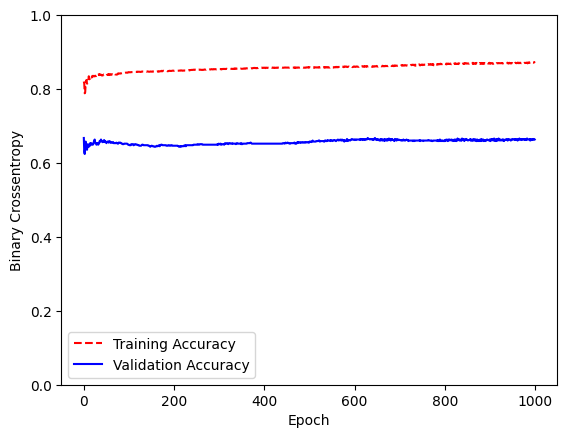

In [51]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')

  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [52]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - binary_accuracy: 0.6760 - f1_score: 0.7594 - loss: 1.2695 - precision: 0.7172 - recall: 0.7774
Test accuracy: 67.60%
Test loss: 1.269


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


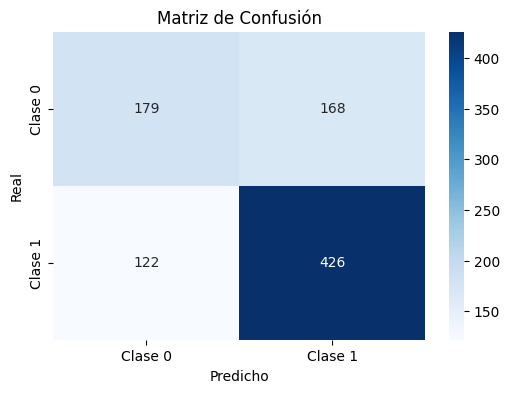

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.59      0.52      0.55       347
     Clase 1       0.72      0.78      0.75       548

    accuracy                           0.68       895
   macro avg       0.66      0.65      0.65       895
weighted avg       0.67      0.68      0.67       895



In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
